# Porto 기본 EDA
자동차 보험 계약자가 클레임을 제기할 가능성을 예측!

- 평가 지표 : **지니 계수**  

- bin : 이진기능, cat : 범주 기능, 나머지는 연속적  
- target : 보험 계약자 소송이 제기되었는지 여부  
- 결측치는 -1로 바꿔서 표시되어 있음!  

## 데이터 준비

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

In [ ]:
!pip install plotly

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
print(df.shape, df_test.shape)

#59개 변수, train은 595212개, test는 892816개,,?

(595212, 59) (892816, 58)


In [4]:
# 중복값 제거 : duplicate
df.drop_duplicates()
df_test.drop_duplicates()

print(df.shape, df_test.shape) #중복값은 없는 듯!

(595212, 59) (892816, 58)


In [5]:
# info 이용해서 data type(integer/float) 판단하기

df.info() # null 값이 없다고 뜨는 이유는 -1로 대체되었기 때문!
# -1 값을 NAN 값으로 대체시켜줘도 됨!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

## Meta Data 저장  
데이터 관리를 용이하게 하기 위해, 데이터 프레임에 meta information을 저장하기!

- 1) 종류 : 범주형(nominal, ordinal, binary), 연속형(interval)  

- 2) dtype : int, float, str  


In [6]:
data = []

for f in df.columns:
    # Defining the role
    if f == 'target' :
        role = 'target'
        
    elif f == 'id' :
        role = 'id'
        
    else:
        role = 'input'
        
    # Defining the level
    if 'bin' in f or f == 'target' :
        level = 'binary'
        
    elif 'cat' in f or f == 'id':
        level = 'nominal'
        
    elif df[f].dtype == float :
        level = 'interval'
        
    else: 
        level = 'ordinal'
        
    # Initialize keep to True for all variables except for id
    keep = True
    if f == 'id':
        keep = False
        
    # Defining the data type
    dtype = df[f].dtype
    
    # 딕셔너리 만들기
    f_dict = {
        'varname' : f,
        'role' : role,
        'level' : level, 
        'keep' : keep, 
        'dtype' : dtype
    }
    
    data.append(f_dict) #빈 항목에 딕셔너리 넣기
    
meta = pd.DataFrame(data, columns = ['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace = True) #inplace = True : meta를 다시 재정의 하지 않고 바로 수정!

meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [7]:
# count 변수 추가! (groupby 이용)
# 대상 데이터프레임을 제일 앞에 써주고, groupby()에 집계의 기준이 되는 
# key 변수들을 써주고, 제일 뒤에 집계하려는 연속형 변수이름을 써

pd.DataFrame( {'count' : meta.groupby(['role', 'level'])['role'].size()} ).reset_index()
#reset_index : index다시 설정해줌. 

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


## Data describe

In [8]:
# interval data

v = meta[ (meta.level =='interval') & (meta.keep)].index
df[v].describe() #괄호 꼭 써주기!

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


1. reg 변수
> reg_03 : 결측치 존재(min이 -1)  
> 스케일링 필요 (min, max가 데이터별로 다름)

2. car 변수
> car_12, 14 : 결측치 존재  
> 역시 스케일링 필요해보임. 

3. calc 변수 
> 결측치 미존재  
> max가 셋다 0.9인것으로 보아 비율로 보임. 분포도 셋다 비슷함. 

#### range가 비교적 작음. 아마 데이터의 익명화를 위해 log를 취했을 가능성이 있음. 


In [9]:
# Ordinal 변수

v = meta[(meta.level=='ordinal') & (meta.keep)].index
df[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


car_11에만 결측치 존재, 스케일링 필요!

In [10]:
# Binary 변수

v = meta[ (meta.level=='binary') & (meta.keep)].index
df[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


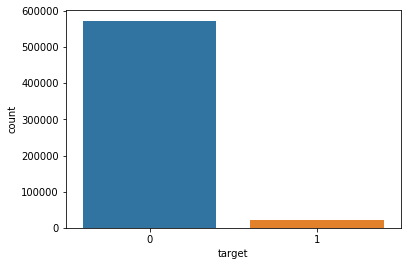

In [11]:
# target 변수 분포 확인(countplot 활용) > 불균형 하다!

sns.countplot(x='target', data=df)
plt.show()

대부분 0이다. 불균형하다!

## Imbalanced data 다루기 (resampling)
target=1보다 0값이 훨씬 많음.  따라서 target=1인 것을 *oversampling* 하거나, target=0인 것을 *undersampling* 해야함!
> oversampling : 데이터를 복제함.   
> undersampling : 클래스의 개수를 줄임.유용한 정보가 버려질 수도 있음

In [12]:
# Undersampling

desired_apriori=0.10

# index 추출
idx_0 = df[df.target == 0].index
idx_1 = df[df.target == 1].index

# 각 index의 길이 추출
nb_0 = len(df.loc[idx_0])
nb_1 = len(df.loc[idx_1])

# undersampling rate, resulting number of records with target=0 계산
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
df = df.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


## Data Checks !
### 1) 결측치 확인 
결측치는 -1로 나타난다

In [13]:
vars_with_missing = []

for f in df.columns:
    missings = df[df[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/df.shape[0]
        
        print('변수 {}가 {}개의 결측치를 가져요! 결측치 전체의 ({:.2%})에요!'.format(f, missings, missings_perc))
        
print('{}개의 변수들이 결측치를 가져요!'.format(len(vars_with_missing)))
        

변수 ps_ind_02_cat가 103개의 결측치를 가져요! 결측치 전체의 (0.05%)에요!
변수 ps_ind_04_cat가 51개의 결측치를 가져요! 결측치 전체의 (0.02%)에요!
변수 ps_ind_05_cat가 2256개의 결측치를 가져요! 결측치 전체의 (1.04%)에요!
변수 ps_reg_03가 38580개의 결측치를 가져요! 결측치 전체의 (17.78%)에요!
변수 ps_car_01_cat가 62개의 결측치를 가져요! 결측치 전체의 (0.03%)에요!
변수 ps_car_02_cat가 2개의 결측치를 가져요! 결측치 전체의 (0.00%)에요!
변수 ps_car_03_cat가 148367개의 결측치를 가져요! 결측치 전체의 (68.39%)에요!
변수 ps_car_05_cat가 96026개의 결측치를 가져요! 결측치 전체의 (44.26%)에요!
변수 ps_car_07_cat가 4431개의 결측치를 가져요! 결측치 전체의 (2.04%)에요!
변수 ps_car_09_cat가 230개의 결측치를 가져요! 결측치 전체의 (0.11%)에요!
변수 ps_car_11가 1개의 결측치를 가져요! 결측치 전체의 (0.00%)에요!
변수 ps_car_14가 15726개의 결측치를 가져요! 결측치 전체의 (7.25%)에요!
12개의 변수들이 결측치를 가져요!


> ps_car_03_cat, ps_car_05_cat는 결측치가 차지하는 퍼센트가 너무 많음! = 제거  
> 나머지는 다 mean이나 mode로 대체해주자!

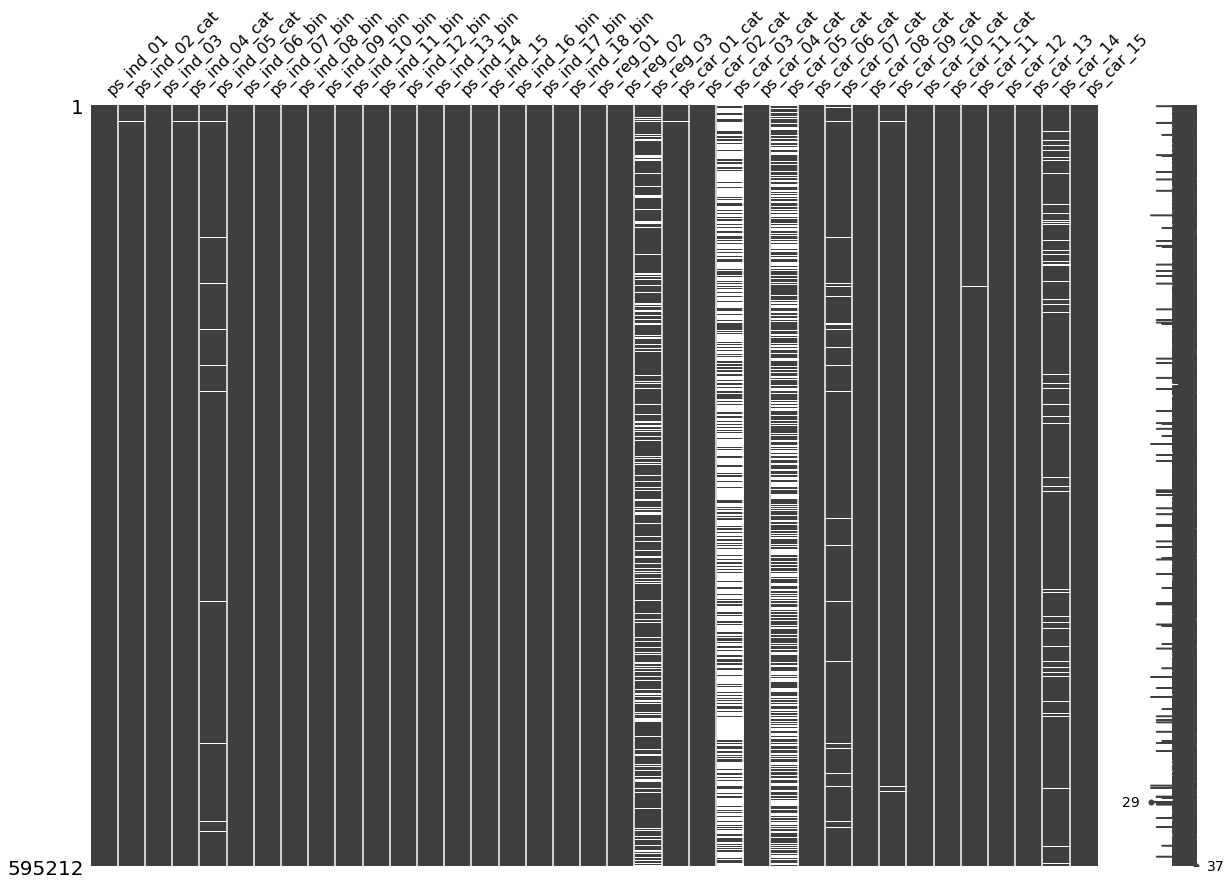

In [38]:
#cf. 만약 결측치 -1을 NAN값으로 변환한다면? 결측치 그림 그릴 수 있다!

df_no = pd.read_csv('train.csv')
df_no.head()

df_no.replace(-1, np.NAN, inplace=True)

# missingno : 결측치 그림으로 나타내기(한눈에 보기)
import missingno as msno
msno.matrix(df=df_no.iloc[:, 2:39], figsize=(20, 14))


In [14]:
### 결측치 바꾸기

# ps_car_03_cat, ps_car_05_cat 드롭하기!
drop_val = ['ps_car_03_cat', 'ps_car_05_cat']
df.drop(drop_val, inplace=True, axis=1)
meta.loc[(drop_val), 'keep'] = False #meta데이터도 업데이트


In [15]:
# mean, mode로 바꾸기(Imputer 사용)

from sklearn.impute import SimpleImputer

mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')

#ravel() : 평평하게 배열
df['ps_reg_03'] = mean_imp.fit_transform(df[['ps_reg_03']]).ravel()
df['ps_car_07_cat'] = mean_imp.fit_transform(df[['ps_car_07_cat']]).ravel()
df['ps_car_09_cat'] = mean_imp.fit_transform(df[['ps_car_09_cat']]).ravel()
df['ps_car_14'] = mean_imp.fit_transform(df[['ps_car_14']]).ravel()
df['ps_ind_05_cat'] = mean_imp.fit_transform(df[['ps_ind_05_cat']]).ravel()

#우선 나머지 결측치는 무시하고 진행해볼게!

### 2) Categorical variables에서 Cardinality 체크
Cardinality : 범주형 변수에서 요소의 개수
> Dummy variable을 형성하기 위해 distinct 정도를 체크해야함!

In [16]:
#value_counts() 함수 이용!

v = meta[ (meta.level == 'nominal') & (meta.keep)].index

for f in v:
    dist_values = df[f].value_counts().shape[0]
    print('변수 {}는 {}개의 distinct value를 가진다!'.format(f, dist_values))
    
# ps_car_11_cat 너무많은거 아니냐?

변수 ps_ind_02_cat는 5개의 distinct value를 가진다!
변수 ps_ind_04_cat는 3개의 distinct value를 가진다!
변수 ps_ind_05_cat는 8개의 distinct value를 가진다!
변수 ps_car_01_cat는 13개의 distinct value를 가진다!
변수 ps_car_02_cat는 3개의 distinct value를 가진다!
변수 ps_car_04_cat는 10개의 distinct value를 가진다!
변수 ps_car_06_cat는 18개의 distinct value를 가진다!
변수 ps_car_07_cat는 3개의 distinct value를 가진다!
변수 ps_car_08_cat는 2개의 distinct value를 가진다!
변수 ps_car_09_cat는 6개의 distinct value를 가진다!
변수 ps_car_10_cat는 3개의 distinct value를 가진다!
변수 ps_car_11_cat는 104개의 distinct value를 가진다!


<Figure size 432x288 with 0 Axes>

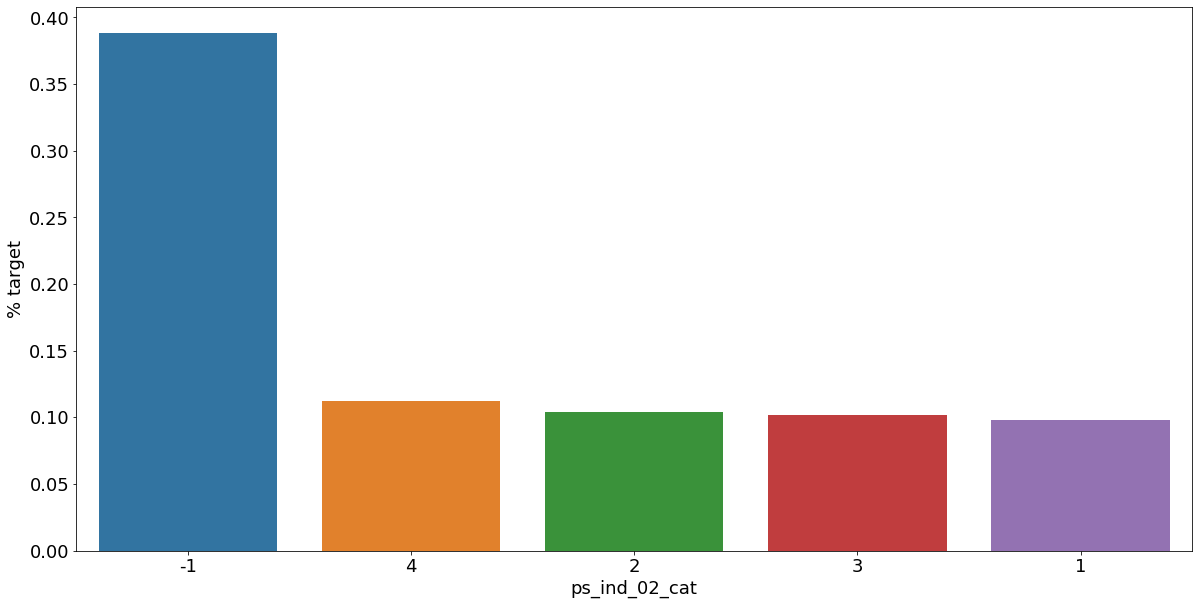

<Figure size 432x288 with 0 Axes>

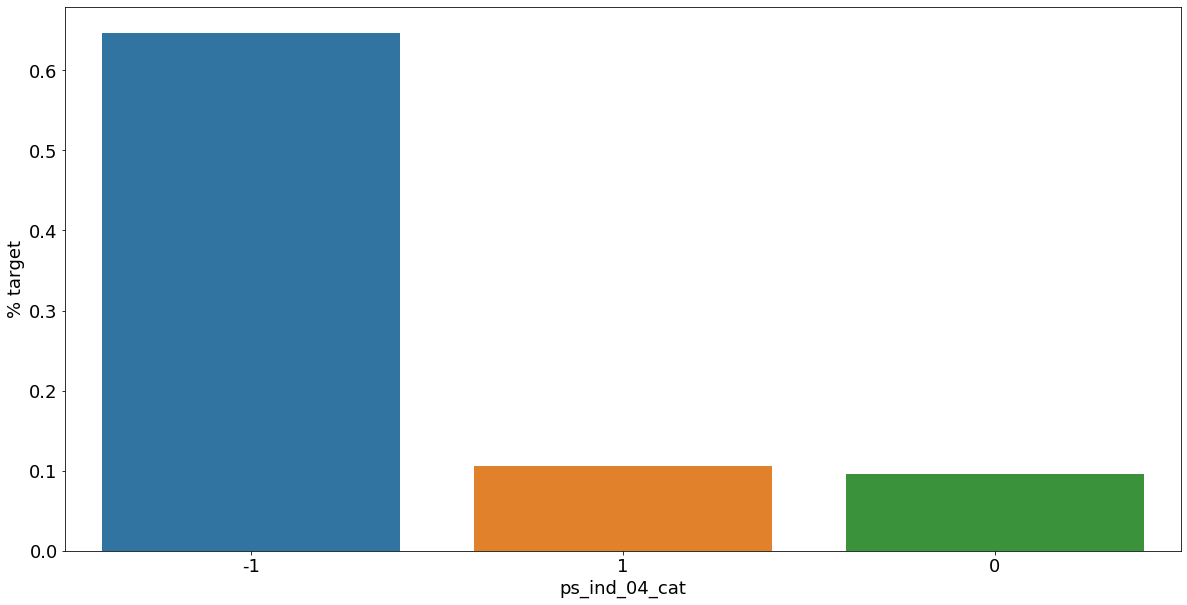

<Figure size 432x288 with 0 Axes>

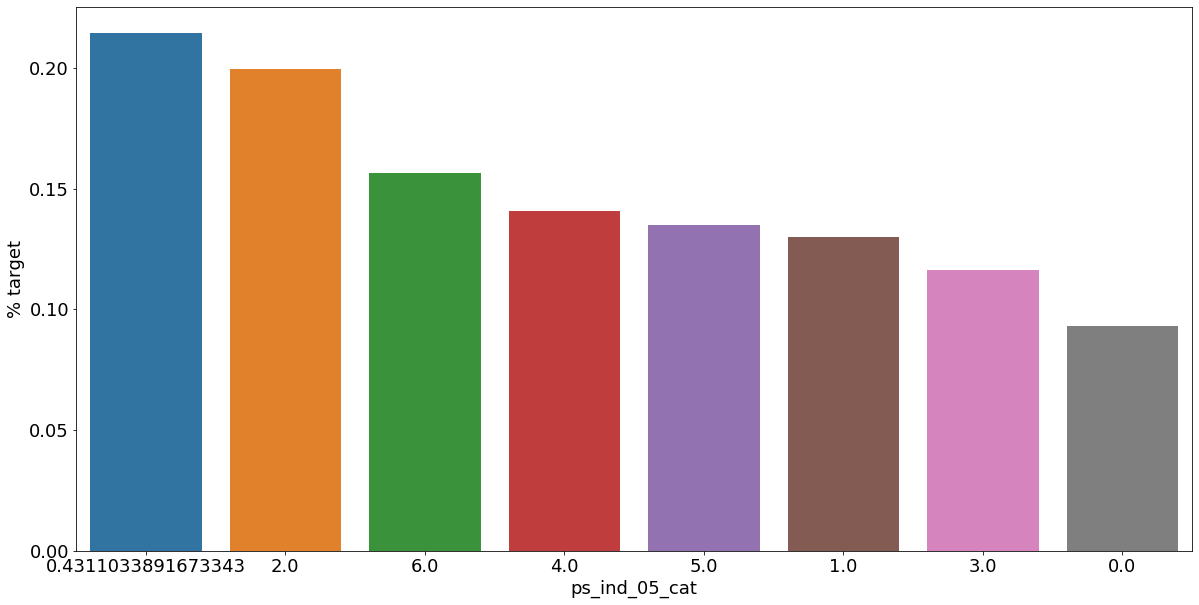

<Figure size 432x288 with 0 Axes>

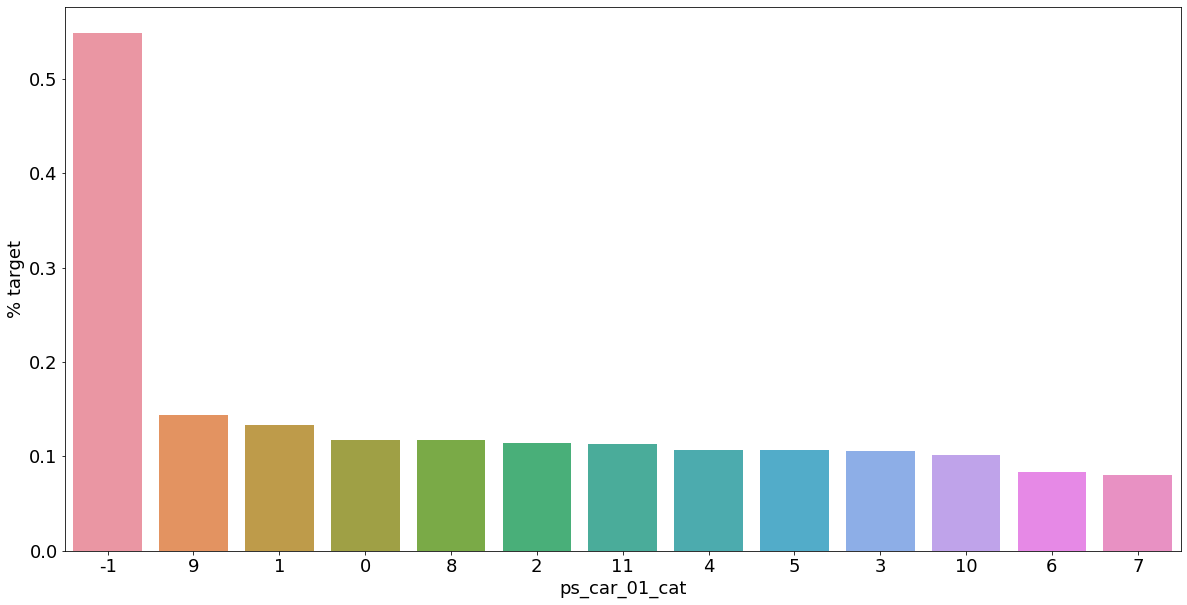

<Figure size 432x288 with 0 Axes>

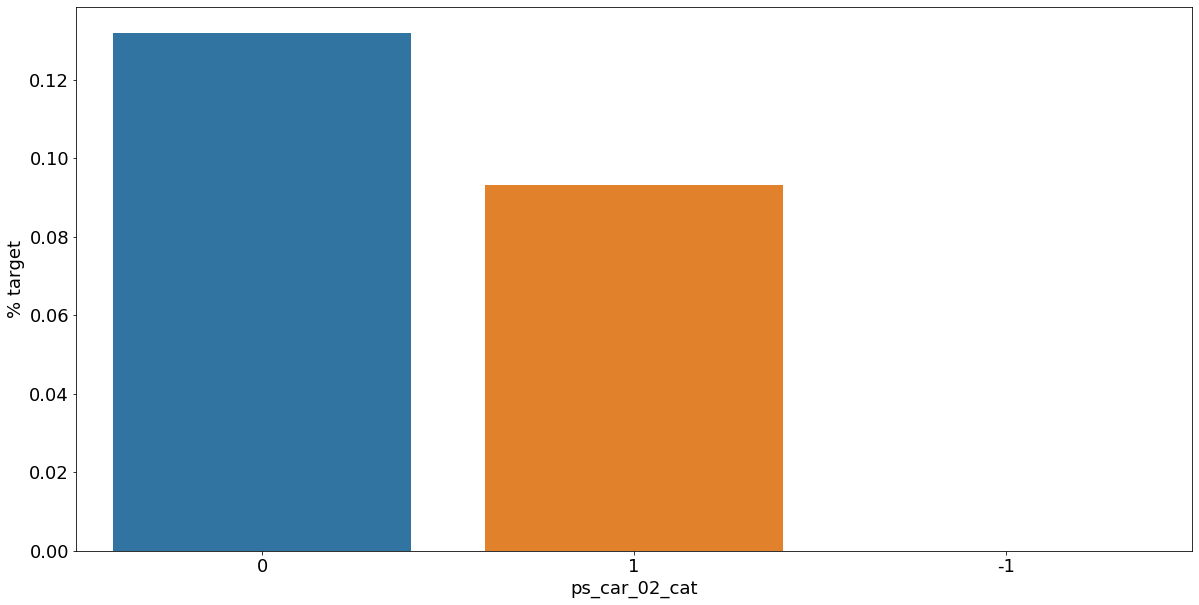

<Figure size 432x288 with 0 Axes>

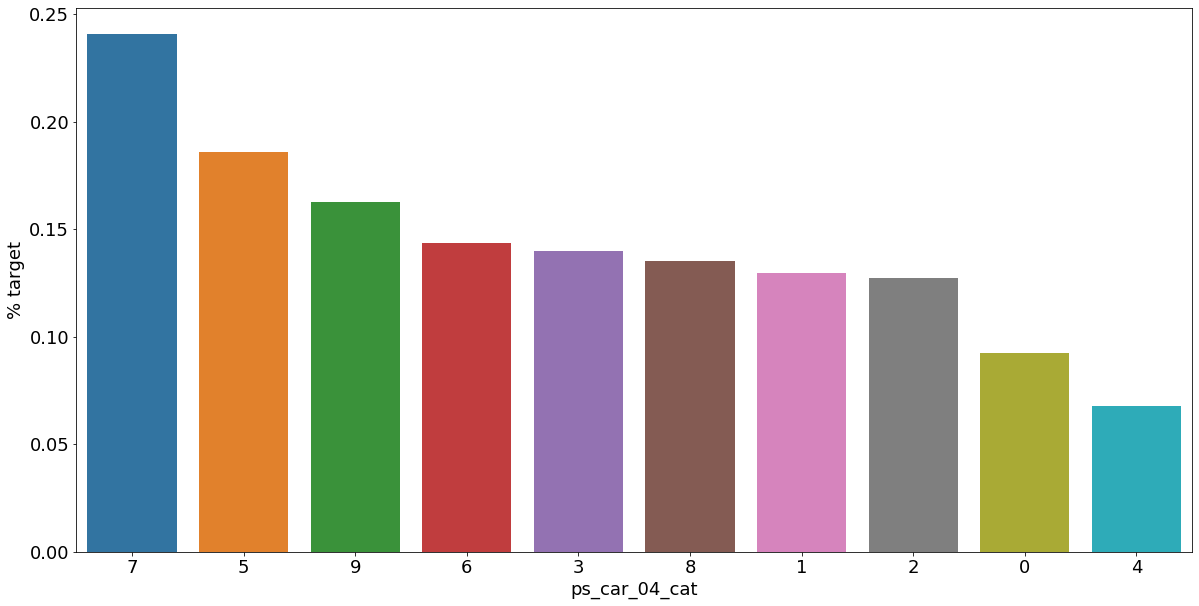

<Figure size 432x288 with 0 Axes>

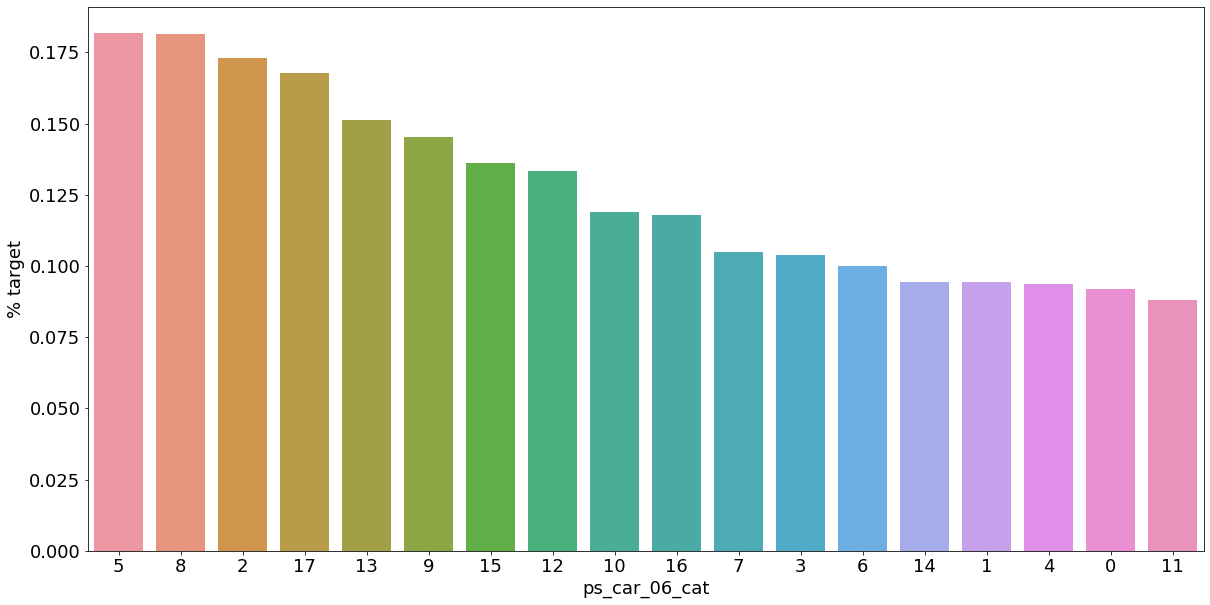

<Figure size 432x288 with 0 Axes>

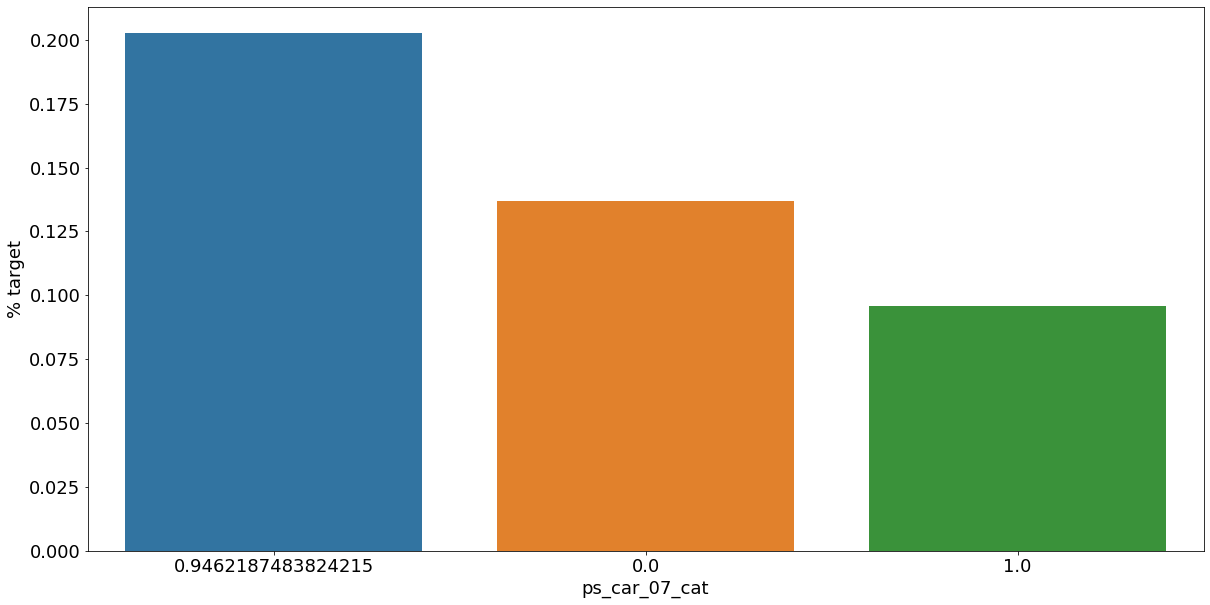

<Figure size 432x288 with 0 Axes>

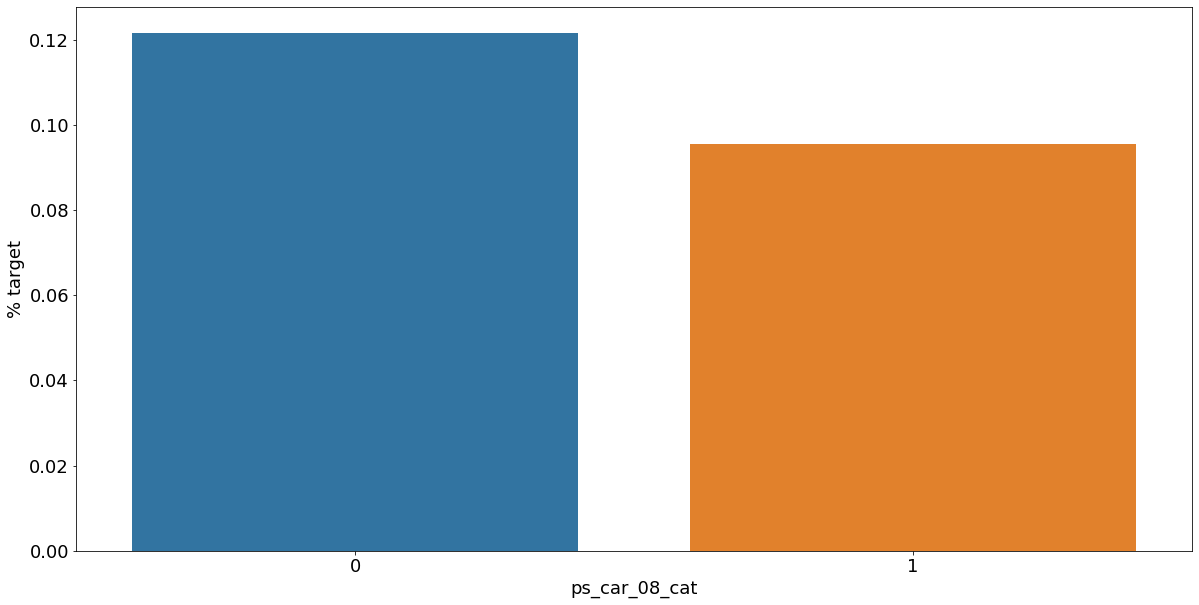

<Figure size 432x288 with 0 Axes>

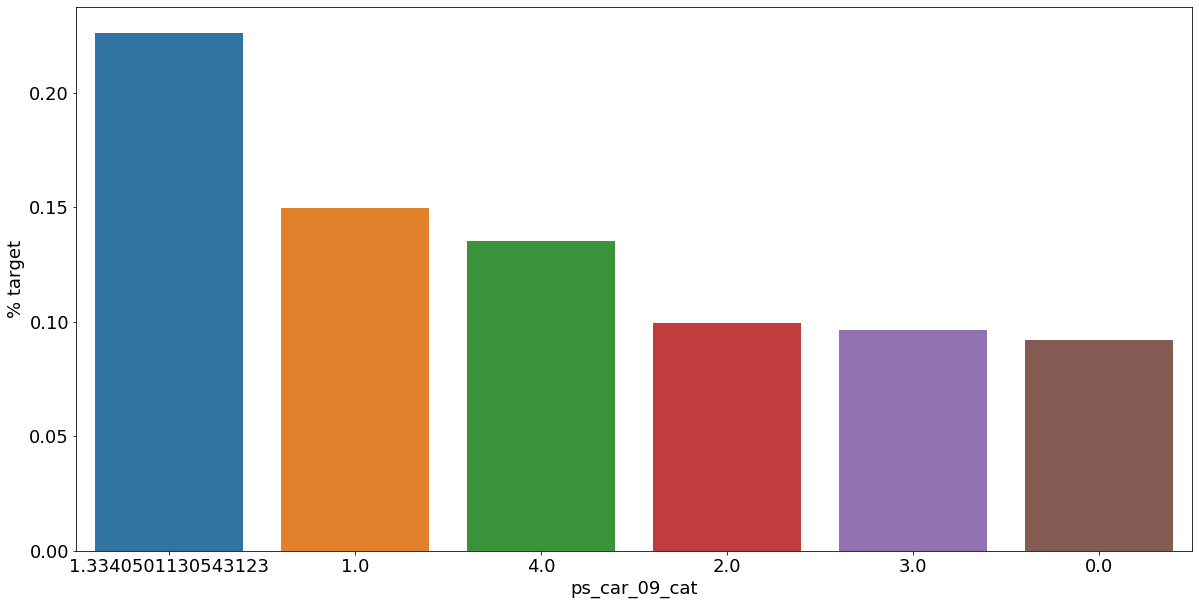

<Figure size 432x288 with 0 Axes>

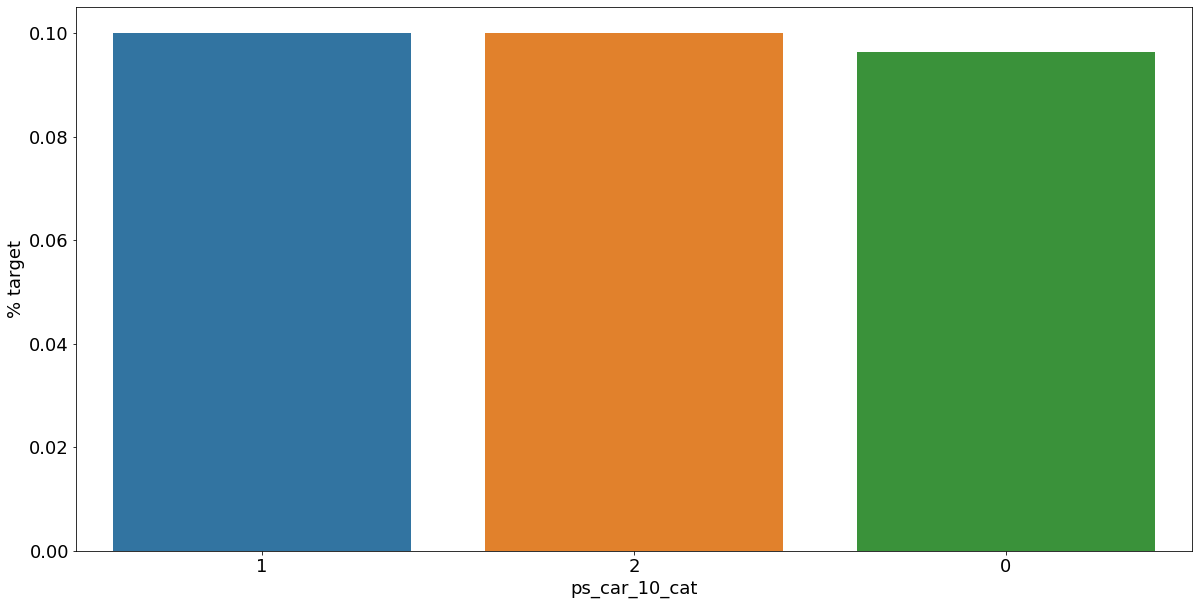

<Figure size 432x288 with 0 Axes>

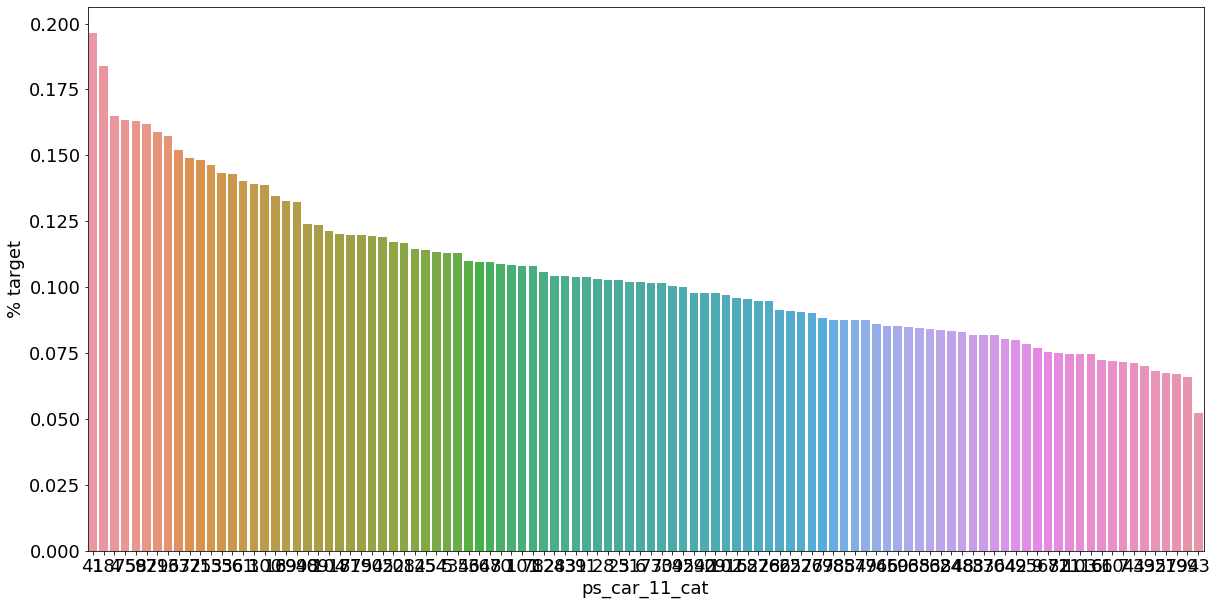

In [17]:
# plot 그리기

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    
    # Calculate the percentage of target=1 per category value
    cat_perc = df[[f, 'target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show();

In [18]:
# # Target encoding with smoothing
# # How weight behaves against value counts is controlled by smoothing parameter
# # https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features

# def add_noise(series, noise_level):
#     return series * (1 + noise_level * np.random.randn(len(series)))

# def target_encode(trn_series=None, 
#                   tst_series=None, 
#                   target=None, 
#                   min_samples_leaf=1, 
#                   smoothing=1,
#                   noise_level=0):
#     assert len(trn_series) == len(target)
#     assert trn_series.name == tst_series.name
#     temp = pd.concat([trn_series, target], axis=1)
#     # Compute target mean 
#     averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
#     # Compute smoothing
#     smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
#     # Apply average function to all target data
#     prior = target.mean()
#     # The bigger the count the less full_avg is taken into account
#     averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
#     averages.drop(["mean", "count"], axis=1, inplace=True)
#     # Apply averages to trn and tst series
#     ft_trn_series = pd.merge(
#         trn_series.to_frame(trn_series.name),
#         averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
#         on=trn_series.name,
#         how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
#     # pd.merge does not keep the index so restore it
#     ft_trn_series.index = trn_series.index 
    
#     ft_tst_series = pd.merge(
#         tst_series.to_frame(tst_series.name),
#         averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
#         on=tst_series.name,
#         how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
#     # pd.merge does not keep the index so restore it
#     ft_tst_series.index = tst_series.index
#     return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [19]:
# train_encoded, test_encoded = target_encode(df["ps_car_11_cat"], 
#                              df_test["ps_car_11_cat"], 
#                              target=df.target, 
#                              min_samples_leaf=100,
#                              smoothing=10,
#                              noise_level=0.01)
    
# df['ps_car_11_cat_te'] = train_encoded
# df.drop('ps_car_11_cat', axis=1, inplace=True)
# meta.loc['ps_car_11_cat','keep'] = False  # Updating the meta
# df_test['ps_car_11_cat_te'] = test_encoded
# df_test.drop('ps_car_11_cat', axis=1, inplace=True)

### 3) Correlation 체크

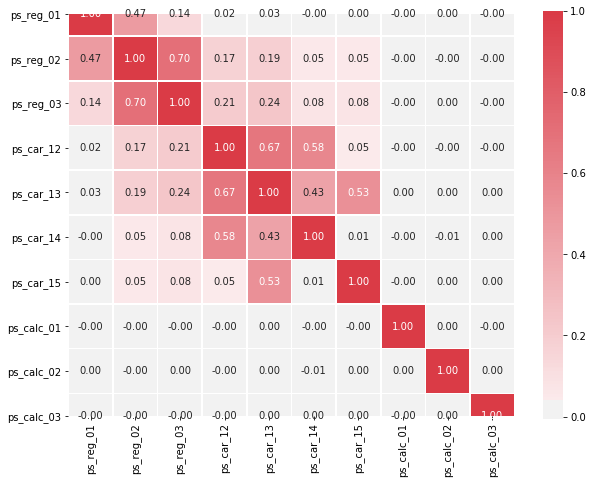

In [20]:
# 히트맵 그리기
## <Interval variable>

def corr_heatmap(v):
    correlations = df[v].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
v = meta[(meta.level == 'interval')&(meta.keep)].index
corr_heatmap(v)

**상관계수 정리(높은순)**
> ps_reg_02 와 ps_reg_03 : 0.7   
> ps_car_12 와 ps_car_13 : 0.67  
> ps_car_12 와 ps_car_14 : 0.58  
> ps_car_13 와 ps_car_15 : 0.53

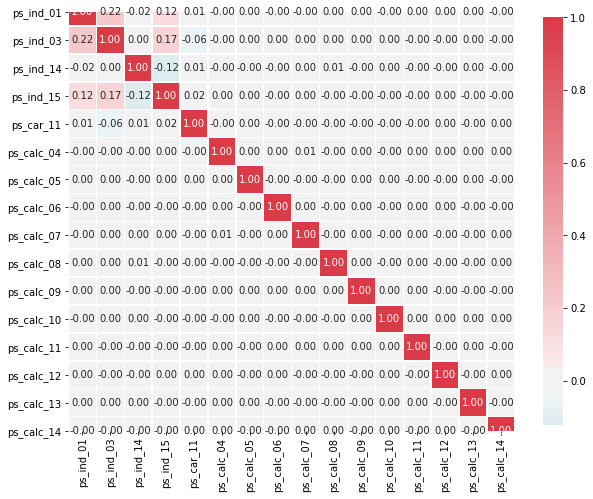

In [21]:
## <Ordinal variables>

v = meta[(meta.level=='ordinal')&(meta.keep)].index
corr_heatmap(v)

In [43]:
## 이항 피쳐 시각화

bin_col = [col for col in df.columns if '_bin' in col]
zero_list = []
one_list = []

for col in bin_col:
    zero_list.append((df[col]==0).sum())
    one_list.append((df[col]==1).sum())
    
trace1 = go.Bar(
    x=bin_col,
    y=zero_list ,
    name='Zero count'
)
trace2 = go.Bar(
    x=bin_col,
    y=one_list,
    name='One count'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title='Count of 1 and 0 in binary variables'
)

fig = go.Figure(data=data, layout=layout)    
py.iplot(fig, filename='stacked-bar')

## Feature Engineering
### 1) Creating 'dummy variables'(범주형)
Dummy variable(가변수) : 범주형 변수를 **연속형 변수**로 만들어줌! 
> - 해당 더미변수에 속하면 1, 아니면 0의 값을 갖게 해준다  
> - 더미변수는 원래 범주형 변수의 범주 개수보다 1개 적게 만든다  
(기준이 되는 변수에 속하는지 속하지 않는지를 따지기 때문!)
> - 효과 : 회귀식에서 해당 변수를 0 또는 상수값으로 만들어 준다!  
> (회귀 기울기를 바꾸지 않고 절편만을 바꾸어 평행하게 움직임)

In [22]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
print('Before dummification we have {} variables in train'.format(df.shape[1]))

Before dummification we have 57 variables in train


In [23]:
df = pd.get_dummies(df, columns=v, drop_first=True)
print('After dummification we have {} variables in train'.format(df.shape[1]))

After dummification we have 211 variables in train


dummy variable 154개나 더함,,!

### 2) Creating 'interaction variables'(연속형)
독립변수는 종속변수와 상관관계가 높아야 하지만, 다른 독립변수들과는 상관관계가 없어야 한다. 이러한 조건이 위배될 때, **다중공선성이 존재**한다고 한다.  
> 만약 상관관계가 높은 독립변수끼리 곱해 새로운 변수(상호작용 변수)를 만들면, 원래 변수들과 다중공선성이 존재할 수밖에 없다. 

http://blog.naver.com/PostView.nhn?blogId=victor3dh&logNo=220859769663

In [24]:
# PolynomialFeatures : 입력값을 다항식으로 변환

v = meta[ (meta.level == 'interval') & (meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(df[v]), columns=poly.get_feature_names(v))
interactions.drop(v, axis=1, inplace=True)

In [25]:
print('Before creating interactions we have {} variables in train'.format(df.shape[1]))

df = pd.concat([df, interactions], axis=1)
print('After creating interactions we have {} variables in train'.format(df.shape[1]))

Before creating interactions we have 211 variables in train
After creating interactions we have 266 variables in train


### 3) Feature Selection : 분산이 낮거나 0인 feature 지우기
피쳐의 특징이 일정하다면(0의 분산) 흥미로운 패턴을 찾는데 이용될 수 없다.  
따라서 일정수준 분산이 안되는 피쳐는 제거한다 ( **VarianceThreshold** 이용)

In [26]:
selector = VarianceThreshold(threshold=0.01)
selector.fit(df.drop(['id', 'target'], axis=1)) # 이 두개 빼고 학습

f = np.vectorize(lambda x:not x) # 왜 vectorize 하냐?????

v = df.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

103 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_ind_05_cat_2.0', 'ps_ind_05_cat_5.0', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_1.3340501130543123', 'ps_car_09_cat_4.0', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_11_cat_2', 'ps_car_11_cat_3', 'ps_car_11_cat_4', 'ps_car_11_cat_6', 'ps_car_11_cat_7', 'ps_car_11_cat_8', 'ps_car_11_cat_9', 'ps_car_11_cat_13', 'ps_car_11_cat_14', 'ps_car_11_cat_15', 'ps_car_11_cat_17', 'ps_car_11_cat_18', 'ps_car_11_cat_19', 'ps_car_11_cat_20', 'ps_car_11_cat_21', 'ps_car_11_cat_23', 'ps_car_11_cat_24', 'ps_car_11_cat_25', 'ps_car_11_cat_26', 'ps_car_11_cat_29', 'ps_car_11_cat_30', 'ps_car_11_cat_31', 'ps_car_11_cat_33', 'ps_car_

너무 많다,, 다른방법 찾자,,

In [28]:
# Random Forest와 SelectFromModel 이용해서 피쳐 select하기(중요도 구하기)

X_train = df.drop(['id', 'target'], axis=1)
y_train = df['target']

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X_train, y_train)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]], importances[indices[f]]))

 1) ps_car_13^2                    0.016903
 2) ps_car_13                      0.016885
 3) ps_car_12 ps_car_13            0.016679
 4) ps_reg_03 ps_car_13            0.016679
 5) ps_car_13 ps_car_14            0.016607
 6) ps_reg_01 ps_car_13            0.016337
 7) ps_car_13 ps_car_15            0.016208
 8) ps_reg_03 ps_car_14            0.015732
 9) ps_reg_03 ps_car_12            0.015217
10) ps_reg_03 ps_car_15            0.014794
11) ps_car_13 ps_calc_03           0.014472
12) ps_car_14 ps_car_15            0.014434
13) ps_car_13 ps_calc_01           0.014399
14) ps_car_13 ps_calc_02           0.014354
15) ps_reg_01 ps_reg_03            0.014299
16) ps_reg_02 ps_car_13            0.014296
17) ps_reg_03^2                    0.014049
18) ps_reg_03                      0.013967
19) ps_reg_01 ps_car_14            0.013866
20) ps_reg_03 ps_calc_02           0.013525
21) ps_reg_03 ps_calc_03           0.013499
22) ps_reg_03 ps_calc_01           0.013455
23) ps_car_14 ps_calc_02        

In [46]:
# # Scatter plot (너무느려ㅠㅠㅠ)

# trace = go.Scatter(
#     y = importances, 
#     x = X_train,
#     mode='markers',
#     marker=dict(
#         sizemode = 'diameter',
#         sizeref = 1,
#         size = 13,
        
#         #size= rf.feature_importances_,
#         #color = np.random.randn(500), #set color equal to a variable
#         color = importances,
#         colorscale='Portland',
#         showscale=True
#     ),
#     text = X_train
# )
# data = [trace]

# layout= go.Layout(
#     autosize= True,
#     title= 'Random Forest Feature Importance',
#     hovermode= 'closest',
#      xaxis= dict(
#          ticklen= 5,
#          showgrid=False,
#         zeroline=False,
#         showline=False
#      ),
#     yaxis=dict(
#         title= 'Feature Importance',
#         showgrid=False,
#         zeroline=False,
#         ticklen= 5,
#         gridwidth= 2
#     ),
#     showlegend= False
# )
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig,filename='scatter2010')

In [30]:
#SelectFromModel : 중요도가 지정된 임계치보다 큰 모든 모델을 선택하는 방법

sfm = SelectFromModel(rf, threshold='median', prefit=True)
print('Number of features before selection: {}'.format(X_train.shape[1]))

n_features = sfm.transform(X_train).shape[1]
print('Number of features after selection: {}'.format(n_features))

selected_vars = list(feat_labels[sfm.get_support()])

df = df[selected_vars + ['target']]

Number of features before selection: 264
Number of features after selection: 132


### 4) Feature Scaling
StandardScaler 이용!

In [48]:
scaler = StandardScaler()
scaler.fit_transform(df.drop(['target'], axis=1))

array([[-0.45941104, -1.26665356,  1.25877984, ..., -0.72553616,
        -1.01071913, -1.06173767],
       [ 1.55538958,  0.95034274,  1.25877984, ..., -1.06120876,
        -1.01071913,  0.27907892],
       [ 1.05168943, -0.52765479,  1.25877984, ...,  1.95984463,
        -0.56215309, -1.02449277],
       ...,
       [-0.9631112 ,  0.58084336, -0.7944201 , ..., -0.46445747,
         0.18545696,  0.27907892],
       [-0.9631112 , -0.89715418,  1.25877984, ..., -0.91202093,
        -0.41263108,  0.27907892],
       [-0.45941104, -1.26665356, -0.7944201 , ...,  0.28148164,
        -0.11358706, -0.72653353]])

## 보완 필요
- resampling
- feature selecting 
- 변수 중요도 측정